# 3. Data and Error Analysis

In [1]:
import torch
import spacy
import numpy as np
import polars as pl
from datasets import Dataset
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from plotting_preferences_AS import plotting_preferences_AS

In [2]:
plotting_preferences_AS()

In [3]:
train_new = pl.read_csv("./data/improved_train.csv")

In [4]:
train_new.columns

['ID',
 'source_type',
 'source',
 'first_half',
 'second_half',
 'LABEL',
 'first_half_length',
 'second_half_length',
 'TEXT']

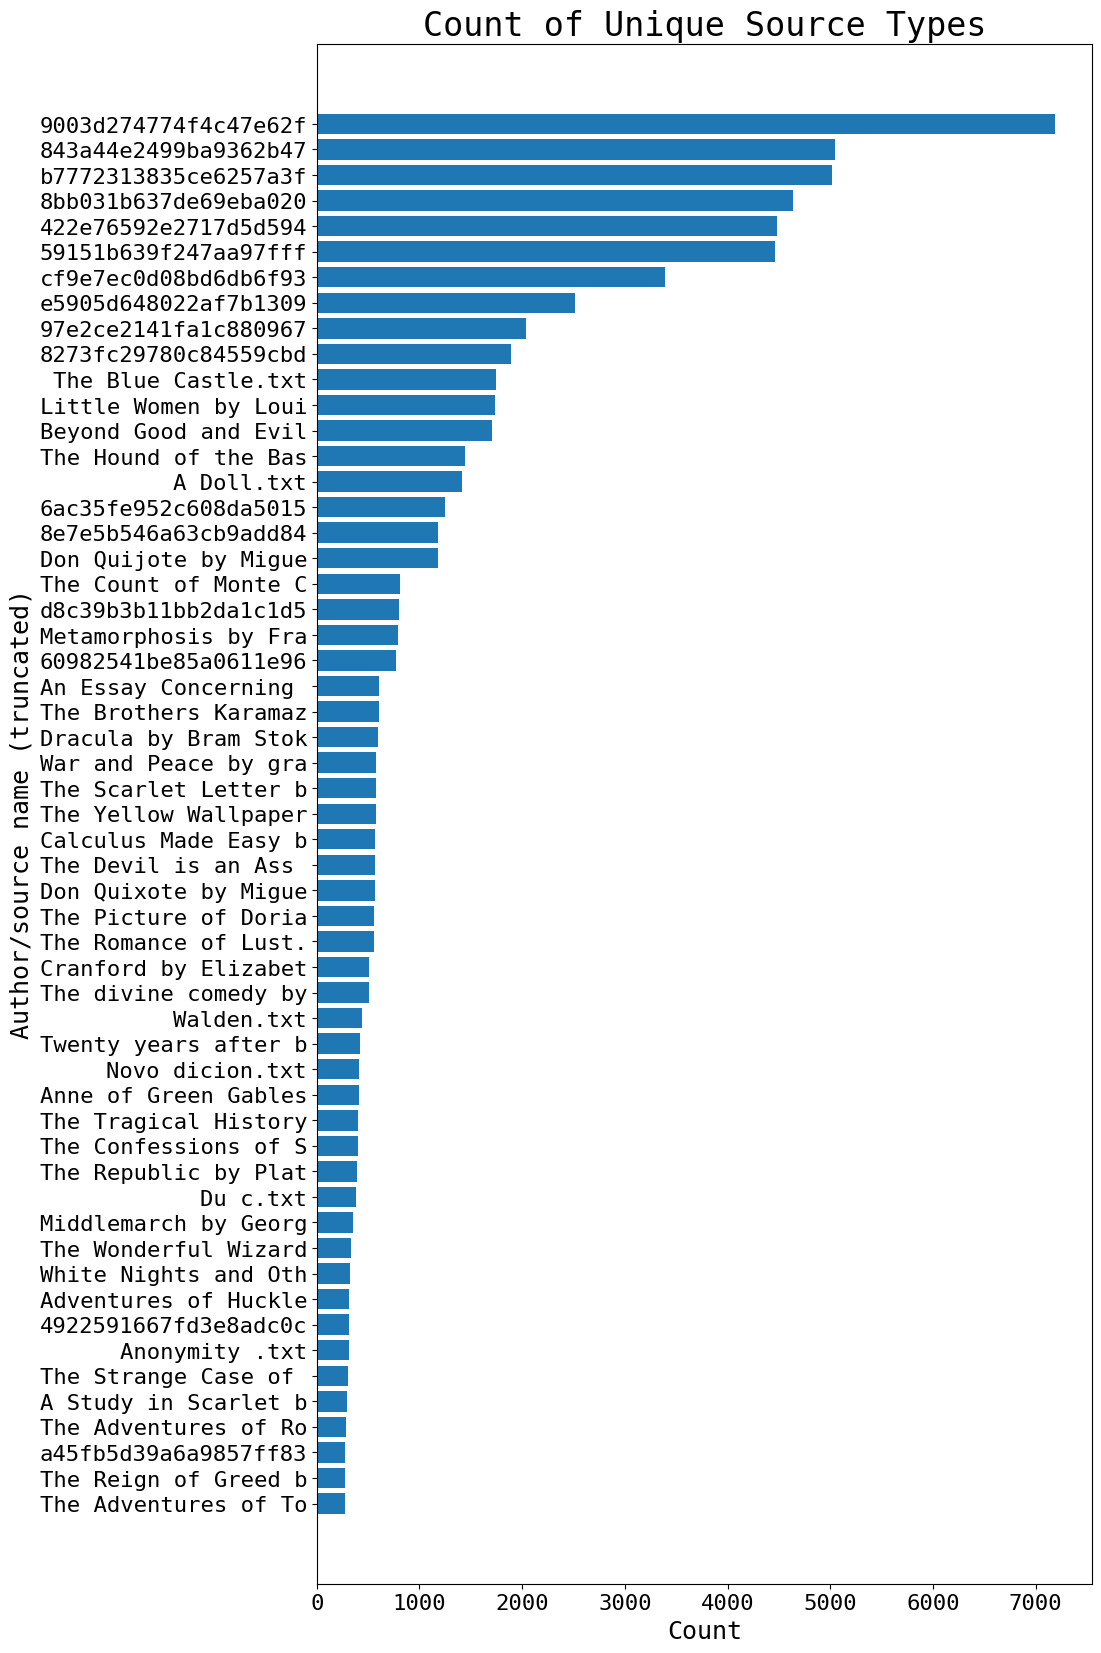

In [23]:
# plotting number of unique sources and their counts
source_type_counts = (
    train_new.group_by("source")
    .agg(pl.count("source").alias("count"))
    .sort("count", descending=True)
)

x = source_type_counts["source"]
x = [i[:20] for i in x]
y = source_type_counts["count"]

plt.figure(figsize=(10, 20))
plt.barh(x, y)
plt.gca().invert_yaxis()  # To make the highest count appear at the top
plt.xlabel("Count")
plt.ylabel("Author/source name (truncated)")
plt.title("Count of Unique Source Types")

plt.savefig(
    "./plots/count_by_source.png",
    dpi=300,
    bbox_inches="tight"
)

In [25]:
train_given = pl.read_csv("./data/train.csv")

In [28]:
len(train_given.filter(train_given["LABEL"] == 0))

1245

In [29]:
len(train_given.filter(train_given["LABEL"] == 1))

356

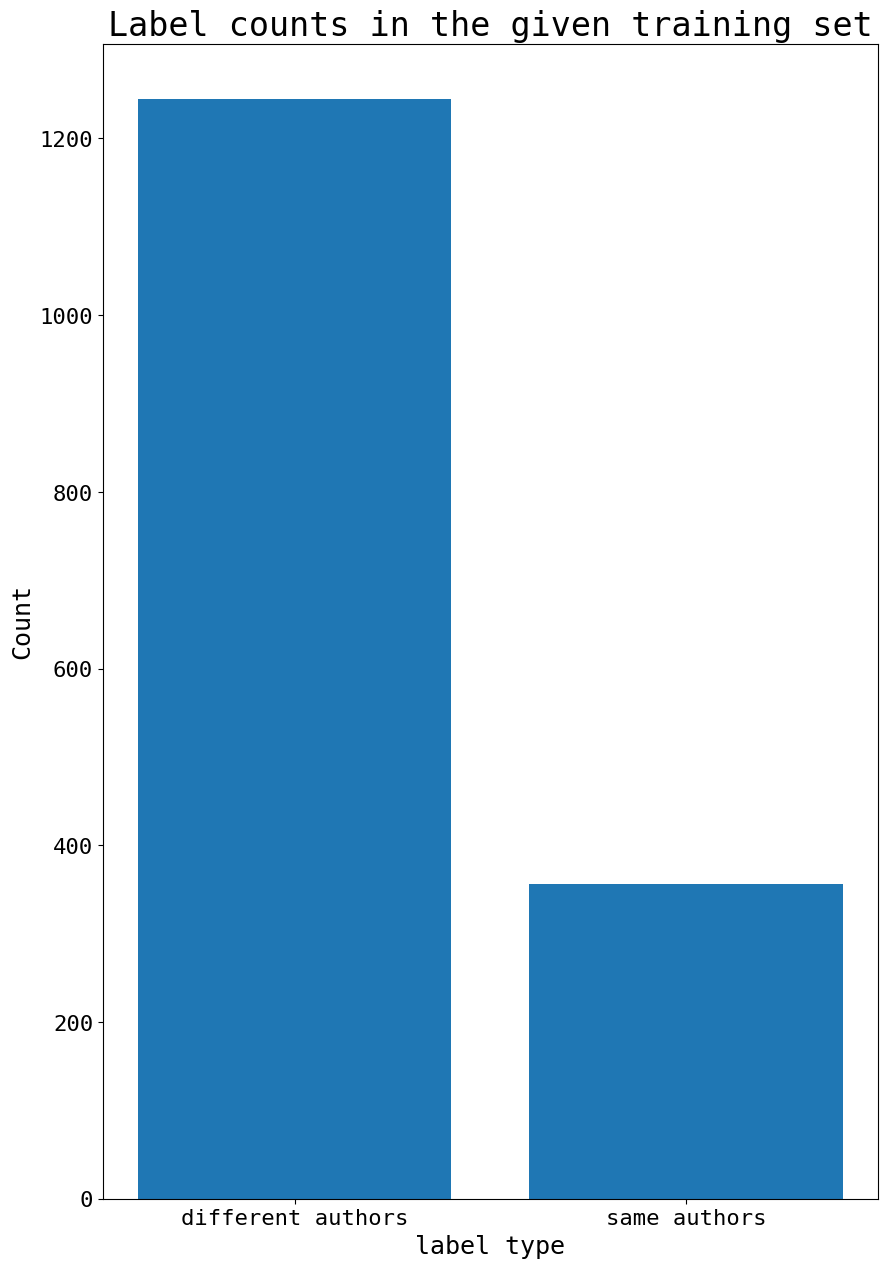

In [37]:
x =["different authors", "same authors"]
y = [
    len(train_given.filter(train_given["LABEL"] == 0)),
    len(train_given.filter(train_given["LABEL"] == 1))
]

plt.figure(figsize=(10, 15))
plt.bar(x, y)
plt.ylabel("Count")
plt.xlabel("label type")
plt.title("Label counts in the given training set")


plt.savefig(
    "./plots/count_by_source_orig.png",
    dpi=300,
    bbox_inches="tight"
)

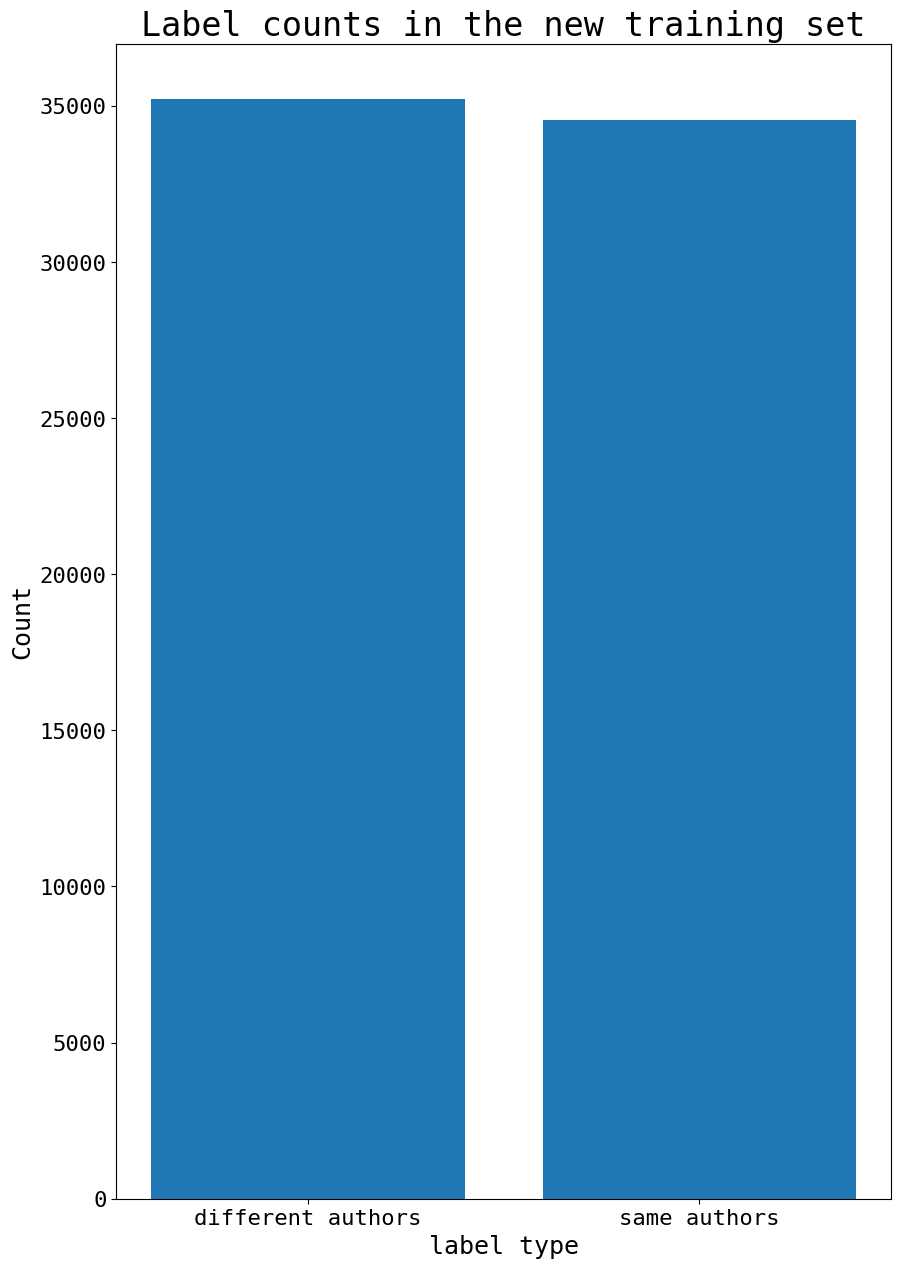

In [38]:
x =["different authors", "same authors"]
y = [
    len(train_new.filter(train_new["LABEL"] == 0)),
    len(train_new.filter(train_new["LABEL"] == 1))
]

plt.figure(figsize=(10, 15))
plt.bar(x, y)
plt.ylabel("Count")
plt.xlabel("label type")
plt.title("Label counts in the new training set")


plt.savefig(
    "./plots/count_by_source_new.png",
    dpi=300,
    bbox_inches="tight"
)

### Checking authorship uniqueness

Code generated using GPT-4o.

Prompt: "For a dictionary with key and pair values of authors and text written by them 
how do I determine authorship uniqueness using spacy?"

In [13]:
new_compiled = pl.read_csv("./data/refined/mega_txt_list.csv")

In [14]:
new_compiled = new_compiled.filter(~pl.col("source").str.slice(-4).eq(".csv"))
new_compiled

source,text,length
str,str,i64
"""843a44e2499ba9362b47a089b0b0ce…","""I don't know what it is about …",1136
"""9003d274774f4c47e62f77600b08ac…","""When five-year-old Kioko final…",570
"""422e76592e2717d5d59465d22d74d4…","""Slick's review posted on Guilt…",2071
"""422e76592e2717d5d59465d22d74d4…","""Angeline's review posted at Gu…",1279
"""b7772313835ce6257a3fbe7ad2649a…","""I loved Jake there's only so m…",571
…,…,…
"""Doctrina Christiana .txt""","""“ ‘Receiving bread from us, th…",2585
"""Doctrina Christiana .txt""","""The most painful secrets of th…",2422
"""Doctrina Christiana .txt""","""“I know you would all like it …",2661


In [15]:
new_compiled_dict = {
    i: j for i, j in zip(new_compiled["source"], new_compiled["text"])
}

In [0]:
# loading SpaCy model
nlp = spacy.load("en_core_web_sm")

# Metrics calculation
author_metrics = {}

for author, text in new_compiled_dict.items():
    doc = nlp(text)
    
    # Sentence length variability
    sentence_lengths = [len(sent) for sent in doc.sents]
    length_variability = np.std(sentence_lengths)
    
    # Function word ratio (using SpaCy stopwords)
    function_words = [token.text for token in doc if token.is_stop]
    function_word_ratio = len(function_words) / len(doc) if len(doc) > 0 else 0
    
    # Noun-to-Verb ratio
    pos_counts = Counter(token.pos_ for token in doc)
    noun_to_verb_ratio = pos_counts.get("NOUN", 0) / pos_counts.get("VERB", 0) \
        if pos_counts.get("VERB", 0) != 0 else 0
    
    # Store results
    author_metrics[author] = {
        "Length Variability": length_variability,
        "Function Word Ratio": function_word_ratio,
        "Noun-to-Verb Ratio": noun_to_verb_ratio
    }

In [22]:
author_metrics_df = pl.DataFrame([
    {"Author": author, **metrics}
    for author, metrics in author_metrics.items()
])

print(author_metrics_df)

shape: (95, 4)
┌─────────────────────────────────┬────────────────────┬─────────────────────┬────────────────────┐
│ Author                          ┆ Length Variability ┆ Function Word Ratio ┆ Noun-to-Verb Ratio │
│ ---                             ┆ ---                ┆ ---                 ┆ ---                │
│ str                             ┆ f64                ┆ f64                 ┆ f64                │
╞═════════════════════════════════╪════════════════════╪═════════════════════╪════════════════════╡
│ 843a44e2499ba9362b47a089b0b0ce… ┆ 9.629414           ┆ 0.576271            ┆ 0.743243           │
│ 9003d274774f4c47e62f77600b08ac… ┆ 11.905881          ┆ 0.517857            ┆ 2.166667           │
│ 422e76592e2717d5d59465d22d74d4… ┆ 15.10389           ┆ 0.525473            ┆ 1.224719           │
│ b7772313835ce6257a3fbe7ad2649a… ┆ 9.856027           ┆ 0.519288            ┆ 0.634615           │
│ 795595616d3dbd81bd16b617c9a1fa… ┆ 5.204805           ┆ 0.517986            ┆ 1.25  

The template for the plotting code was generated with the help of GPT-4o.

Prompt: "These are the columns of a dataframe I have {insert columns}, how do I plot 
the three metrics on a 3 x 1 plot in python? I want barplots" 

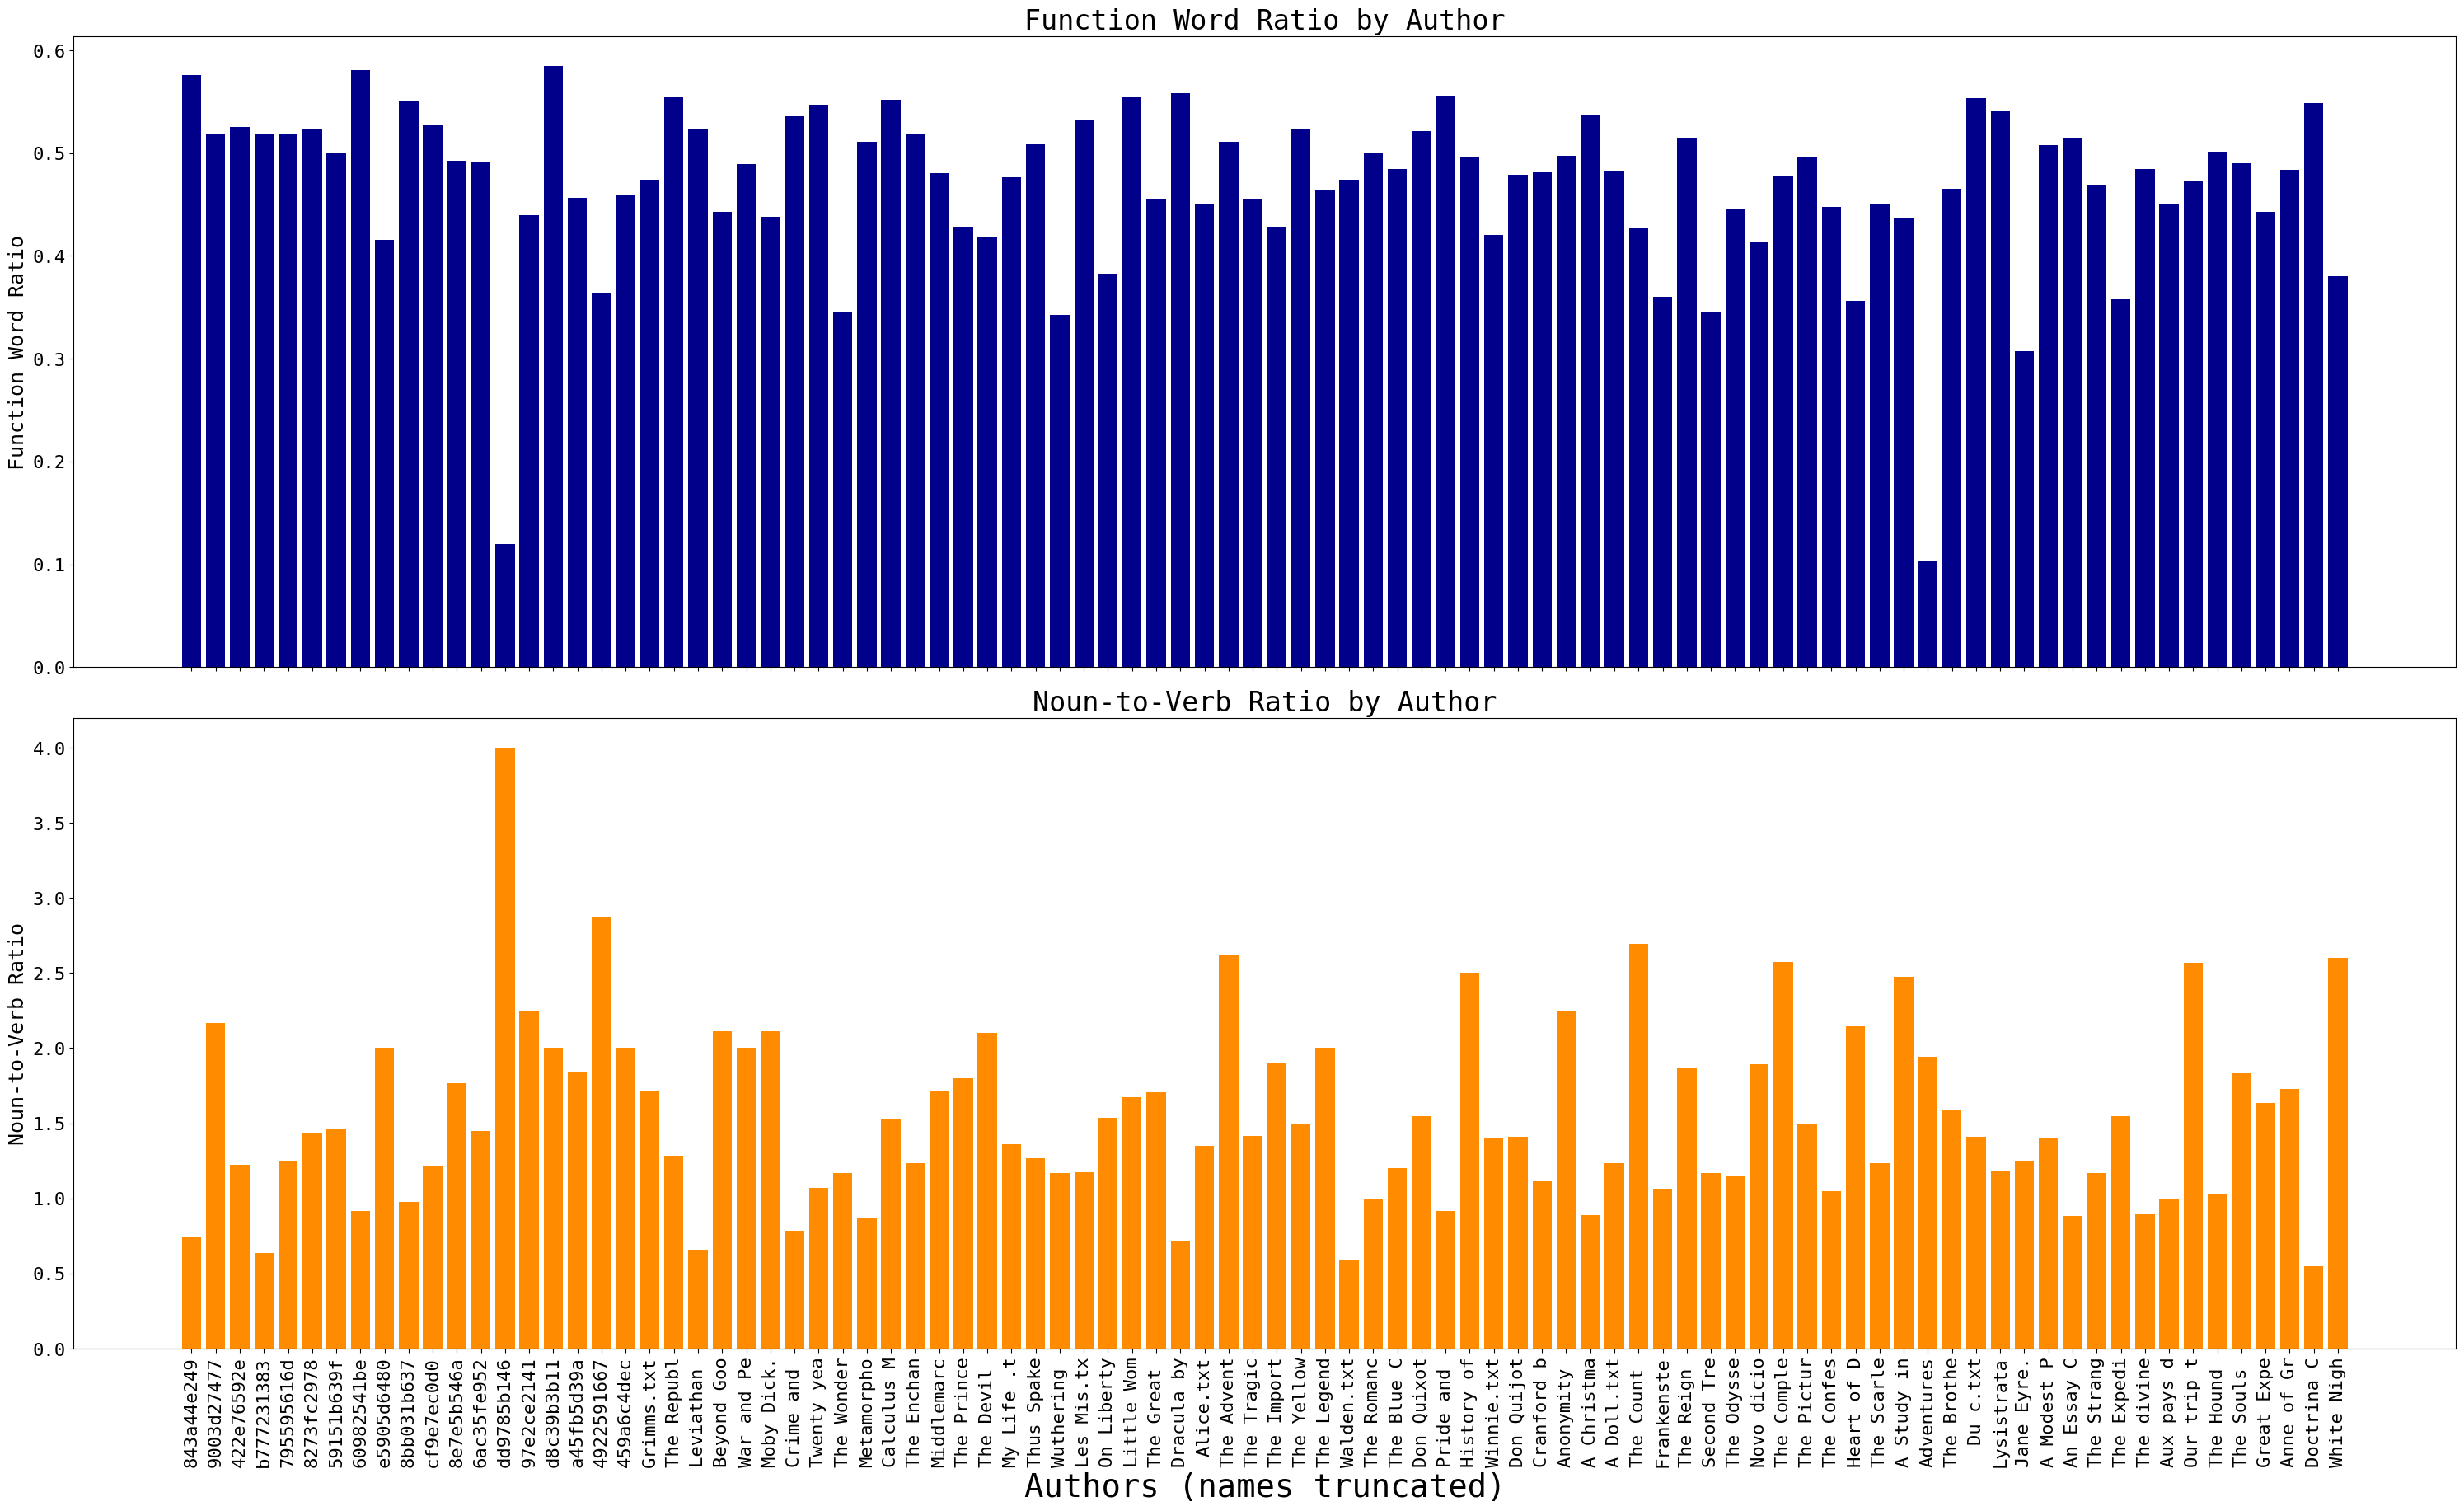

In [34]:
# plotting the computed author metrics
authors = [i[:10] for i in author_metrics.keys()]
length_variability = [metrics["Length Variability"] for metrics in author_metrics.values()]
function_word_ratio = [metrics["Function Word Ratio"] for metrics in author_metrics.values()]
noun_to_verb_ratio = [metrics["Noun-to-Verb Ratio"] for metrics in author_metrics.values()]

# creating a 3 x 1 plot
fig, axes = plt.subplots(2, 1, figsize=(30, 18), sharex=True)

axes[0].bar(authors, function_word_ratio, color="darkblue")
axes[0].set_title("Function Word Ratio by Author")
axes[0].set_ylabel("Function Word Ratio")

axes[1].bar(authors, noun_to_verb_ratio, color="darkorange")
axes[1].set_title("Noun-to-Verb Ratio by Author")
axes[1].set_ylabel("Noun-to-Verb Ratio")
axes[1].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.xlabel("Authors (names truncated)", fontsize=28)
# plt.show()

plt.savefig(
    "./plots/authorship_metrics.png",
    dpi=300,
    bbox_inches="tight"
)

### Error Analysis

In [4]:
val_small = pl.read_csv("./data/improved_val.csv").sample(n=1000)

In [5]:
custom_cache_dir = "../.cache_xdisk/"

# loading RoBERTa
model_name = "FacebookAI/roberta-base"

# loading model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    cache_dir=custom_cache_dir, 
    trust_remote_code=True,
    num_labels=2,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name, 
    cache_dir=custom_cache_dir, 
    trust_remote_code=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
val_small.with_columns(
    pl.col("TEXT").str.replace(
        r"\[SNIPPET\]", 
        tokenizer.sep_token
    )
)

def tokenize_function(df):
    return tokenizer(df["TEXT"], truncation=True, padding="max_length")

test_hf = Dataset.from_polars(val_small)
val_test = test_hf.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
# load the best model
best_model = "./results_1209/checkpoint-22605"
another_attempt = "./results_1209/checkpoint-4000"

trained_model = AutoModelForSequenceClassification.from_pretrained(
    best_model
)
trained_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [8]:
# making and retrieving predictions
input_ids = val_test["input_ids"]
attention_mask = val_test["attention_mask"]

input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)

# passing tensors to the model
with torch.no_grad():
    outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    val_labels = torch.argmax(logits, dim=-1).numpy()

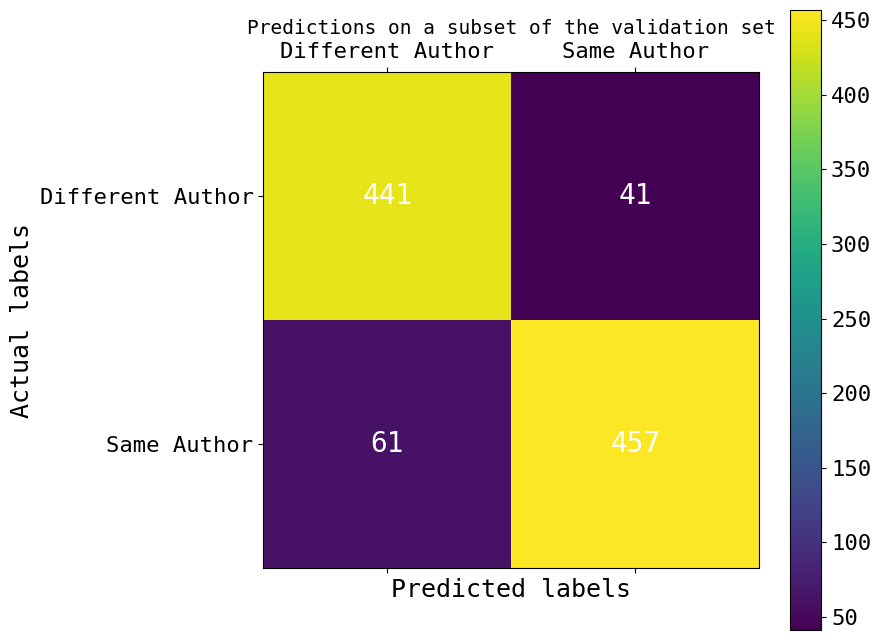

In [9]:
# creating a confusion matrix
confuse = confusion_matrix(val_small["LABEL"], val_labels)
class_labels = ["Different Author", "Same Author",] 

plt.matshow(confuse) 
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Predictions on a subset of the validation set", fontsize=14)

# adding the labels to both axes
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)

# adding counts in the middle
for i in range(len(confuse)):
    for j in range(len(confuse[i])):
        plt.text(
            j, 
            i, 
            str(confuse[i][j]), 
            ha="center", 
            va="center", 
            color="white",
            fontsize=20
        )
        

plt.savefig(
    "./plots/pred_of_best_model_validation_subset_.png",
    dpi=300,
    bbox_inches="tight",
)